In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import collections
import heapq


from scipy import linalg
from tqdm.notebook import tqdm
from sklearn.cross_decomposition import CCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
GLOVE_PATH = '/mnt/guanabana/raid/data/datasets/GloVe/pretrained/glove.6B.300d.txt'
CAVS_PATH = '../data/filtered_broden_cavs.pickle'
EMBEDDING_PATH = '../data/word_embedding_6B_300D.pickle'
TEXTURE_PATH = "/raid/data/datasets/broden1_384/c_texture.csv"

In [3]:
textures = pd.read_csv(TEXTURE_PATH, index_col = 0)
texture_list = list(textures['name'])

Read the concept activation vectors from the Broden dataset as a dictionary

In [4]:
with open(CAVS_PATH, 'rb') as handle:
        cavs_broden = pickle.load(handle)

Extract the word embeddings from the GloVe dataset. The word embeddings are stored in a dictionary, with the word as key and vector as value, and in a matrix (400 000 x 300). The dataset contains about 400K words.

In [5]:
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as handle:
        embedding_dict = pickle.load(handle)

    glove_embedding_matrix = np.load('../data/glove_embedding_matrix.npy')
else:
    embedding_dict = {}
    glove_embedding_matrix = np.zeros((400000, 300))

    with open(GLOVE_PATH, 'r', encoding="utf-8") as f:
        for i, line in tqdm(enumerate(f)):
            
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32').reshape(1,-1)
            embedding_dict[word] = vector

            glove_embedding_matrix[i] = vector
                        
    with open(EMBEDDING_PATH, 'wb') as handle:
        pickle.dump(embedding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
     
    np.save('../data/glove_embedding_matrix.npy', glove_embedding_matrix)

Select the concepts from the Broden dataset, which are also available as word embedding. Several concepts in the Broden dataset end with _'-s'_. This is removed to get more concepts linked with an embedding. 

In [6]:
# list all Broden concepts
all_broden_concepts = list(cavs_broden.keys())

# remove duplicates from concept list (e.g. mountain-s is stored when mountain and mountain-s are both in the dataset)
# and remove the textures from the concepts
no_dups_concepts = [c for c in all_broden_concepts if c +'-s' not in all_broden_concepts and c not in texture_list]

In [7]:
# create a matrix of all cavs
cav_matrix = np.zeros((len(no_dups_concepts), cavs_broden[no_dups_concepts[0]]['cav'].shape[1]))
for i in range(len(no_dups_concepts)):
    cav = cavs_broden[no_dups_concepts[i]]['cav']
    cav_matrix[i] = cav

# remove the '-s' from the concepts if present 
broden_concepts = [c[:-2] if c[-2:] == '-s' else c for c in no_dups_concepts]

In [8]:
cav_matrix.shape

(649, 2048)

Remove the '-s' from the _scene_ concepts and store the matching cavs with the word embeddings. The index is stored to remove the unavailable concepts from the CAV matrix

In [9]:
embedding_ix_concepts = [(idx, c) for idx, c in enumerate(broden_concepts) if c in embedding_dict.keys()]

# store the indices of concepts which are present in both datasets
embedding_idxs = [ix for ix, n in embedding_ix_concepts]
embedding_concepts = [c for ix, c in embedding_ix_concepts]

In [10]:
print("The amount of CAVs with a corresponding word embedding: ", len(embedding_idxs))

The amount of CAVs with a corresponding word embedding:  373


In [11]:
cavs_with_embedding = cav_matrix[embedding_idxs]

In [12]:
cavs_with_embedding.shape

(373, 2048)

Create a matrix of the word embeddings for the concepts which also have a CAV.

In [13]:
embeddings_with_cav = np.zeros((len(embedding_idxs), 300))
for i in range(len(embedding_concepts)):
    word_vec = embedding_dict[embedding_concepts[i]].reshape(1,-1)
    embeddings_with_cav[i] = word_vec

In [14]:
embeddings_with_cav.shape

(373, 300)

## Manifold alignment

Transpose the input data to column matrices

In [79]:
cavs_col = cavs_with_embedding.T
glove_col = embeddings_with_cav.T

cavs_norm = normalize(cavs_with_embedding)
glove_norm = normalize(embeddings_with_cav)

To perform manifold allignment the MatLab code from Devis Tuia is followed: https://github.com/dtuia/KEMA/blob/master/general_routine/KMA.m

In [80]:
n_samples = len(embedding_concepts)
MU = 0.5
LAMBDA = 0.5

In [81]:
cav_knn_graph = kneighbors_graph(cavs_norm, 3, mode = 'connectivity')
cav_knn_graph = cav_knn_graph.toarray()

In [82]:
glove_knn_graph = kneighbors_graph(glove_norm, 3, mode = 'connectivity')
glove_knn_graph = glove_knn_graph.toarray()

In [83]:
W = linalg.block_diag(cav_knn_graph, glove_knn_graph)
D = np.diag(np.sum(W, axis=1))

Similarity matrix (Ws) encodes the samples belonging to the same class. In this research, there is a pairwise connections, every CAV only has a single match with a word embedding. This relation can be captured by the identity matrix. <br> The corresponding diagonal row sum matrix (Ds) results from summing Ws along the rows and converting the sums to a diagonal matrix.

The dissimilarity matrix (Wd) encodes which samples do not belong to the same class. This is important to capture, otherwise every sample will end in the same location as this will capture the similarity between the samples. In this research it is assumed that every sample is dissimilar from every other sample except from itself.

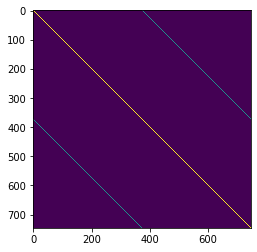

In [84]:
Ws = np.eye(n_samples)
Ws = np.concatenate((Ws, Ws), axis = 1)
Ws = np.concatenate((Ws, Ws), axis =0)
Ws = Ws + np.eye(Ws.shape[0])

Ds = np.diag(np.sum(Ws, axis = 1))

plt.imshow(Ws)

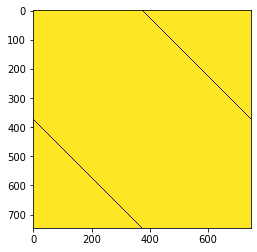

In [85]:
Wd = np.ones(n_samples) - np.eye(n_samples)
Wd = np.concatenate((Wd, Wd), axis=1)
Wd = np.concatenate((Wd, Wd), axis=0)
Wd = Wd + np.eye(Wd.shape[0])

Dd = np.diag(np.sum(Wd, axis=1))

plt.imshow(Wd)

In [86]:
#WHY? --> normalize
Sws = sum(sum(Ws))
Swd = sum(sum(Wd))
Sw = sum(sum(W))

In [87]:
Ws = Ws / Sws * Sw
Wd = Wd / Swd * Sw

In [88]:
Ls = Ds - Ws # graph Laplacian of similarity 
Ld = Dd - Wd # Laplacian of dissimilarity

L = D - W # Laplacian topology/geometry

In [89]:
A = ((1 - MU) * L + MU * Ls) + LAMBDA * np.eye(Ls.shape[0])
B = Ld

In [90]:
kernel_cav = np.matmul(cavs_norm, cavs_norm.T)
kernel_glove = np.matmul(glove_norm, glove_norm.T)

In [70]:
kernel_cav.shape

(373, 373)

In [71]:
K = linalg.block_diag(kernel_cav, kernel_glove)

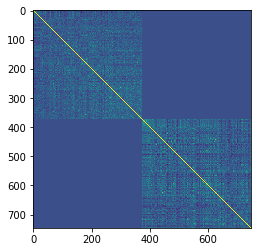

In [72]:
plt.imshow(K)

In [73]:
KA = np.matmul(K,A)
KB = np.matmul(K,B)

KAK = np.matmul(KA, K)
KBK = np.matmul(KB, K)

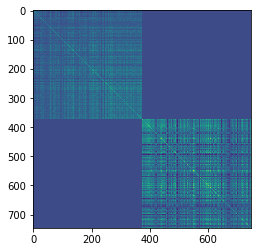

In [74]:
plt.imshow(KBK)

In [93]:
eigenvals, eigenvecs = linalg.eigh(KAK, KBK)

LinAlgError: the leading minor of order 675 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

In [94]:
eigenvecs.shape

(746, 746)

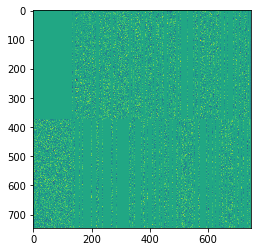

In [95]:
plt.imshow(eigenvecs)

In [ ]:
cav_kernel = eigenvecs[:, :373]
glove_kernel = eigenvecs[:, 373:]

In [ ]:
glove_kernel.shape

In [ ]:
cavs_with_embedding.shape

In [ ]:
cavs_transformed = np.dot(cav_kernel, cavs_with_embedding)

In [ ]:
cavs_transformed.shape

In [ ]:
x = np.asarray([[1,2,3],
               [1,2,3],
               [2,3,4]])
x_norm = normalize(x, norm='l1')

In [ ]:
x_norm

In [ ]:
np.matmul(x_norm, x_norm.T)

## Transform the data using CCA

In [ ]:
cav_glove_concepts = [c for c in cavs_broden.keys() if c in embedding_dict.keys()]

In [ ]:
matrix_cav = np.zeros((len(cav_glove_concepts), 2048))
matrix_glove = np.zeros((len(cav_glove_concepts), 300))

for t in range(len(cav_glove_concepts)):
    matrix_cav[t] = cavs_broden[cav_glove_concepts[t]]['cav'].reshape(1,-1)
    matrix_glove[t] = embedding_dict[cav_glove_concepts[t]].reshape(1,-1)

In [ ]:
matrix_cav.shape

In [ ]:
n_concepts = 20
ccat = CCA(n_components = 2, scale=True, max_iter = 10000, tol=1e-06)

xca, yca = ccat.fit_transform(matrix_glove[:n_concepts], matrix_cav[:n_concepts])
xc = scale(xca)
yc = scale(yca)

test_glove = matrix_glove[n_concepts + 1].reshape(1,-1)
test_cav = matrix_cav[n_concepts + 1].reshape(1,-1)
gc, cc = ccat.transform(test_glove, test_cav)

gc = (gc - xca.mean(axis=0)) / xca.std(axis = 0)
cc = (cc - yca.mean(axis=0)) / yca.std(axis = 0)

In [ ]:
print(yca.std(axis=0))
print(xca.std(axis=0))

In [ ]:
ccat.x_std_.shape

In [ ]:
ccat

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(xc[:,0], xc[:,1], label = 'GloVe')
plt.scatter(yc[:,0], yc[:,1], label = 'CAV', alpha = 0.5)
plt.scatter(gc[:,0], gc[:,1], label = 'GloVe LOO')
plt.scatter(cc[:,0], cc[:,1], label = 'CAV LOO')

for i, txt in enumerate(cav_glove_concepts[:n_concepts]):
    plt.annotate(str(txt), (xc[:,0][i], xc[:,1][i]))
    plt.annotate(str(txt), (yc[:,0][i], yc[:,1][i]))

plt.legend()
plt.show()

### Some more testing -- CCA doesn't seem to work

In [ ]:
n_concepts = 160
test_concepts = embedding_concepts[:n_concepts]

test_embeddings = embeddings_with_cav[:n_concepts]
test_cavs = cavs_with_embedding[:n_concepts]

pca_t = PCA(n_components=10)

emb_pca = pca_t.fit_transform(test_embeddings)
cav_pca = pca_t.fit_transform(test_cavs)

Initialize a canonical correlation model

In [ ]:
n_dimensions = 2
cca_t = CCA(n_components = n_dimensions, scale = True, max_iter = 10000, tol=1e-06)

In [ ]:
cca_t.fit(test_embeddings, test_cavs)

The transform function of the CCA does not seem to work properly as the data is not scaled. Therefore, the data is manually transformed by applying the dot product of the fitted weights and the input data after which it is scaled.

In [ ]:
test_emb_c, test_cavs_c = cca_t.transform(test_embeddings, test_cavs)

test_emb_cs = scale(test_emb_c)
test_cavs_cs = scale(test_cavs_c)

In [ ]:
x_loo = embeddings_with_cav[21].reshape(1,-1)
y_loo = cavs_with_embedding[21].reshape(1,-1)

x_loo_c = (x_loo - test_embeddings.mean(axis=0)) / test_embeddings.std(axis = 0, ddof = 1)
x_loo_c = np.dot(x_loo_c, cca_t.x_rotations_)
x_loo_c = (x_loo_c - test_emb_c.mean(axis = 0) / test_emb_c.std(axis = 0))

y_loo_c = (y_loo - test_cavs.mean(axis=0)) / test_cavs.std(axis = 0, ddof = 1)
y_loo_c = np.dot(y_loo_c, cca_t.y_rotations_)
y_loo_c = (y_loo_c - test_cavs_c.mean(axis=0) / test_cavs_c.std(axis = 0))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(test_emb_cs[:,0], test_emb_cs[:,1], label='GloVe', alpha = 1)
plt.scatter(test_cavs_cs[:,0], test_cavs_cs[:,1], label='CAV', alpha = 0.5)

#plt.scatter(test_emb_c[n_concepts-1,0], test_emb_c[n_concepts - 1, 1], label='GloVe LOO')
#plt.scatter(test_cavs_c[n_concepts-1,0], test_cavs_c[n_concepts - 1, 1], label = 'CAV LOO')
plt.scatter(x_loo_c[:,0], x_loo_c[:,1], label = 'X LOO')
plt.scatter(y_loo_c[:,0], y_loo_c[:,1], label = 'Y LOO')

for i, txt in enumerate(test_concepts):
    plt.annotate(str(txt), (test_emb_cs[:,0][i], test_emb_cs[:,1][i]))
    plt.annotate(str(txt), (test_cavs_cs[:,0][i], test_cavs_cs[:,1][i]))


plt.legend()
plt.show()

## Perform Leave-One-Out cross validation

In [ ]:
num_concepts = 50
n_dim_cca = 20
n_comp_glove_pca = 25
n_comp_cav_pca= 50
num_iter = 1
plot=False

Select the first amount of concepts

In [ ]:
glove_vectors = embeddings_with_cav[:num_concepts]
cav_vectors = cavs_with_embedding[:num_concepts]

Reduce the dimensions of the vectors by applying PCA

In [ ]:
pca_glove = PCA(n_components = 25)
pca_cav = PCA(n_components = 50)

glove_pca_concepts = pca_glove.fit_transform(glove_vectors)
cav_pca_concepts = pca_cav.fit_transform(cav_vectors)

Apply CCA to map the embeddings and CAVs to a latent feature space

In [ ]:
cca = CCA(n_components = 2, scale = True, max_iter = 10000)

glove_cca, cav_cca = cca.fit_transform(glove_pca_concepts, cav_pca_concepts)

glove_ccas = scale(glove_cca)
cav_ccas = scale(cav_cca)

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(glove_ccas[:50,0], glove_ccas[:50,1], label='GloVe')
plt.scatter(cav_ccas[:50,0], cav_ccas[:50,1], label='CAVs', alpha = 0.5)

plt.legend()

# for i, txt in enumerate(embedding_concepts[:num_concepts]):
#     plt.annotate(str(txt), (glove_m[:,0][i], glove_m[:,1][i]))
#     plt.annotate(str(txt), (cav_m[:,0][i], cav_m[:,1][i]))

plt.show()

Choose a new concept and extract the vectors

In [ ]:
glove_test_concept = embeddings_with_cav[num_concepts+1].reshape(1,-1)
cav_test_concept = cavs_with_embedding[num_concepts+1].reshape(1,-1)

In [ ]:
glove_test_pca = pca_glove.transform(glove_test_concept)
cav_test_pca = pca_cav.transform(cav_test_concept)

glove_test_cca, cav_test_cca = cca.transform(glove_test_pca, cav_test_pca)

glove_test_ccas = (glove_test_cca - glove_cca.mean(axis=0)) / glove_cca.std(axis = 0)
cav_test_ccas = (cav_test_cca - cav_cca.mean(axis=0)) / cav_cca.std(axis = 0)

In [ ]:
cav_test_pca.shape

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(glove_ccas[:50,0], glove_ccas[:50,1], label='GloVe')
plt.scatter(cav_ccas[:50,0], cav_ccas[:50,1], label='CAVs', alpha = 0.5)
plt.scatter(glove_test_ccas[:,0], glove_test_ccas[:,1], label='LOO GloVe')
plt.scatter(cav_test_ccas[:,0], cav_test_ccas[:,1], label = 'LOO CAV')
plt.legend()

# for i, txt in enumerate(embedding_concepts[:num_concepts]):
#     plt.annotate(str(txt), (glove_m[:,0][i], glove_m[:,1][i]))
#     plt.annotate(str(txt), (cav_m[:,0][i], cav_m[:,1][i]))

plt.show()